## Prototype and feature cosine similarity visualization

In [75]:
import numpy as np
import torch


In [76]:

import numpy as np
def cos_to_sin(cosine):
    return np.sqrt(1-cosine**2)
def cos_ab(cos_a, cos_b):
    sin_a = cos_to_sin(cos_a)
    sin_b = cos_to_sin(cos_b)
    # cos(a+b)
    cos_ab = cos_a*cos_b - sin_a*sin_b
    return cos_ab


In [77]:
from models.networks import make_model
from easydict import EasyDict
model_cfg = {
        "name":"vqreptunet1x1",
        "params":{
            "encoder_name":"resnet50",
            "num_classes":3,
            "depth": 5,
            "vq_cfg":{
                "num_embeddings":[0, 0, 512, 512, 512],
                "distance":"euclidean",
                "kmeans_init": True
                },
            "margin":0.5,
            "scale":30.0,
            "use_feature":False,
            "encoder_weights":"imagenet_swsl"
            }
        }
model_cfg = EasyDict(model_cfg)
model = make_model(model_cfg)

In [78]:
weights_file = "../drive/MyDrive/semi_sup_train/CWFID/VQRePTUnet1x1_margin0_55/ckpoints/best_test_miou.pth"
model.load_state_dict(torch.load(weights_file)["model_1"])

<All keys matched successfully>

In [79]:
from PIL import Image
import torchvision.transforms.functional as TF
test_img = "/content/data/semi_sup_data/CWFID/num30/test/input/060_image_5.png"
test_img = Image.open(test_img).convert("RGB").resize((448, 448), resample=Image.BILINEAR)
test_img = TF.to_tensor(test_img) # (0, 1사이)
test_img = test_img.unsqueeze(0)



/tmp/ipykernel_2602481/680263816.py:4: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  test_img = Image.open(test_img).convert("RGB").resize((448, 448), resample=Image.BILINEAR)


In [80]:
model = model.cuda()
model.eval()
pred = model(test_img.cuda())

In [81]:
features = model.encoder(test_img.cuda())[1:]
for i in range(len(features)):
    quantize, _embed_index, commitment_loss, code_usage = model.codebook[i](features[i])
    features[i] = quantize
    decoder_out = model.decoder(*features)
    output = model.segmentation_head(decoder_out)

In [82]:
decoder_out = decoder_out.detach().cpu().numpy()


In [83]:
prototypes = model.prototype_loss.embedding.weight.data.detach().cpu().numpy()

In [84]:
flatten_decoder_out = decoder_out.transpose(0, 2, 3, 1).reshape(-1, 32)

In [85]:
print(flatten_decoder_out.shape)
print(prototypes.shape)


(50176, 32)
(3, 32)


In [86]:
def img_to_label(target_img, pixel_to_label_dict:dict):
    pixels = list(pixel_to_label_dict.keys())
    output = target_img
    for pixel in pixels:
        output = np.where(output==int(pixel), pixel_to_label_dict[pixel], output)
    return output.astype(np.int64)
test_target = "/content/data/semi_sup_data/CWFID/num30/test/target/060_image_5.png"
test_target = Image.open(test_target).convert("L")
test_target = test_target.resize(decoder_out.shape[-2:], resample=Image.NEAREST)
test_target = np.array(test_target)
test_target = img_to_label(test_target, {0:0, 128:1, 255:2})
flatten_target = test_target.reshape(-1)
flatten_target.shape



/tmp/ipykernel_2602481/2703144007.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  test_target = test_target.resize(decoder_out.shape[-2:], resample=Image.NEAREST)


(50176,)

In [87]:
l2_prototypes = prototypes/np.linalg.norm(prototypes, ord=2, axis=-1, keepdims=True)
cos_0 = l2_prototypes[0] @ np.array([1]+[0]*31).T
cos_1 = l2_prototypes[1] @ np.array([1]+[0]*31).T
cos_2 = l2_prototypes[2] @ np.array([1]+[0]*31).T

In [88]:
print(f'''cos_bg : {cos_0}
cos_weed : {cos_1}
cos_crop: {cos_2}''')

cos_bg : -0.17859604954719543
cos_weed : 0.1538698673248291
cos_crop: -0.22129568457603455


In [89]:
sin_0, sin_1, sin_2 = map(cos_to_sin, [cos_0, cos_1, cos_2])
prototypes_coord = np.array([[cos_0, sin_0], [cos_1, sin_1], [cos_2, sin_2]])

In [90]:
prototypes_coord

array([[-0.17859605,  0.98392248],
       [ 0.15386987,  0.98809112],
       [-0.22129568,  0.97520676]])

In [91]:
l2_features = flatten_decoder_out/np.linalg.norm(flatten_decoder_out, ord=2, axis=-1, keepdims=True)
cos_feats = l2_features @ np.array([1]+[0]*31).T
sin_feats = cos_to_sin(cos_feats)

In [93]:
sin_feats.shape

(50176,)

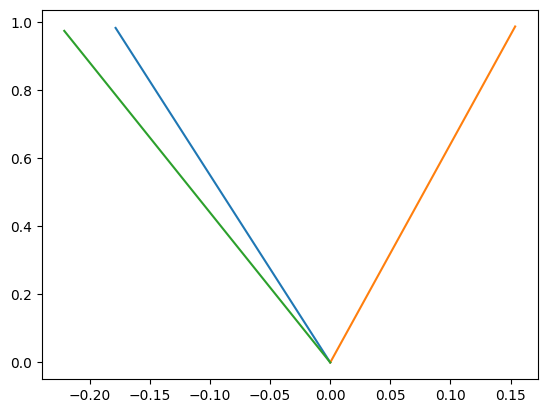

In [94]:
import matplotlib.pyplot as plt
for i in range(prototypes_coord.shape[0]):
    plt.plot([0, prototypes_coord[i][0]], [0, prototypes_coord[i][1]])
plt.show()

In [95]:
prototpye_cos = np.array([cos_0, cos_1, cos_2])
prototpye_sin = np.array([sin_0, sin_1, sin_2])

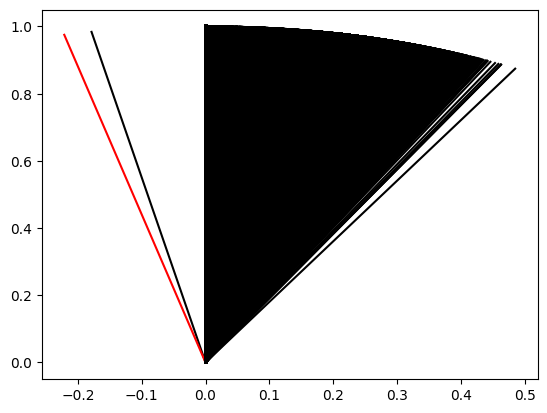

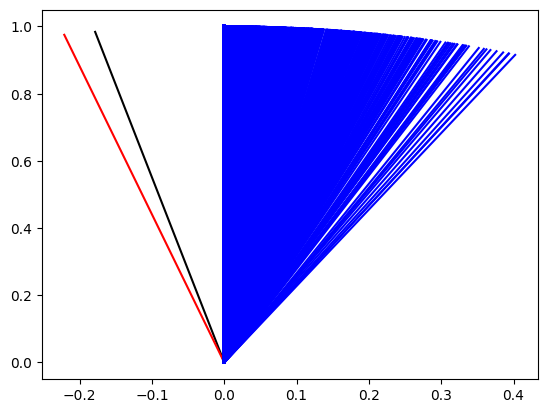

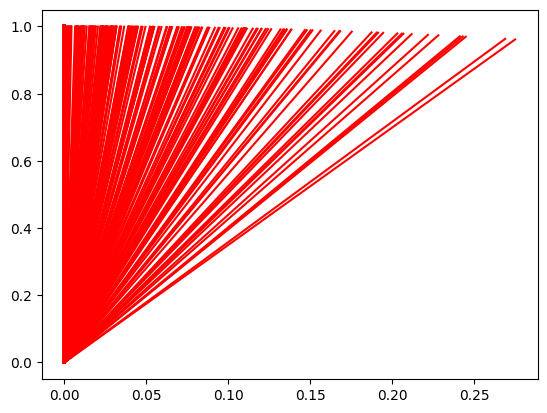

In [96]:
import matplotlib.pyplot as plt
color = ['k', 'b', 'r']
for i in range(prototypes_coord.shape[0]):
    plt.plot([0, prototypes_coord[i][0]], [0, prototypes_coord[i][1]], color=color[i])
for i in range(cos_feats.shape[0]):
    # if cos_alpha[i] > 0.1 and flatten_target[i] !=0:
    # if flatten_target[i] != 0:
    if flatten_target[i] == 0:
        plt.plot([0, cos_feats[i]], [0, sin_feats[i]], color=color[flatten_target[i]])
plt.show()
color = ['k', 'b', 'r']
for i in range(prototypes_coord.shape[0]):
    plt.plot([0, prototypes_coord[i][0]], [0, prototypes_coord[i][1]], color=color[i])
for i in range(cos_feats.shape[0]):
    # if cos_alpha[i] > 0.1 and flatten_target[i] !=0:
    # if flatten_target[i] != 0:
    if flatten_target[i] == 1:
        plt.plot([0, cos_feats[i]], [0, sin_feats[i]], color=color[flatten_target[i]])
plt.show()

for i in range(cos_feats.shape[0]):
    # if cos_alpha[i] > 0.1 and flatten_target[i] !=0:
    # if flatten_target[i] != 0:
    if flatten_target[i] == 2:
        plt.plot([0, cos_feats[i]], [0, sin_feats[i]], color=color[flatten_target[i]])
plt.show()


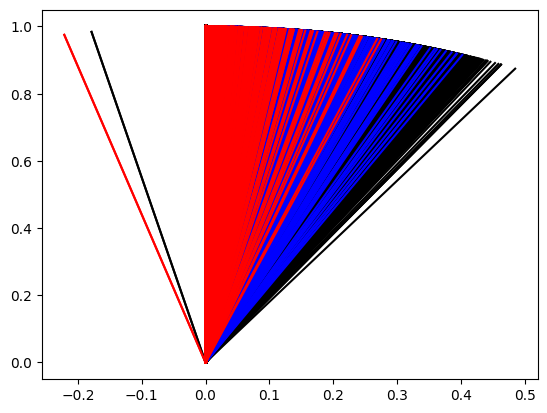

In [97]:
import matplotlib.pyplot as plt
color = ['k', 'b', 'r']
for i in range(prototypes_coord.shape[0]):
    plt.plot([0, prototypes_coord[i][0]], [0, prototypes_coord[i][1]], color=color[i])
for i in range(cos_feats.shape[0]):
    # if cos_alpha[i] > 0.1 and flatten_target[i] !=0:
    # if flatten_target[i] != 0:
    if flatten_target[i] == 0:
        plt.plot([0, cos_feats[i]], [0, sin_feats[i]], color=color[flatten_target[i]])
color = ['k', 'b', 'r']
for i in range(prototypes_coord.shape[0]):
    plt.plot([0, prototypes_coord[i][0]], [0, prototypes_coord[i][1]], color=color[i])
for i in range(cos_feats.shape[0]):
    # if cos_alpha[i] > 0.1 and flatten_target[i] !=0:
    # if flatten_target[i] != 0:
    if flatten_target[i] == 1:
        plt.plot([0, cos_feats[i]], [0, sin_feats[i]], color=color[flatten_target[i]])

for i in range(cos_feats.shape[0]):
    # if cos_alpha[i] > 0.1 and flatten_target[i] !=0:
    # if flatten_target[i] != 0:
    if flatten_target[i] == 2:
        plt.plot([0, cos_feats[i]], [0, sin_feats[i]], color=color[flatten_target[i]])
plt.show()
